# RL4CO Quickstart Notebook

<a href="https://colab.research.google.com/github/kaist-silab/rl4co/blob/main/notebooks/1-quickstart.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

[**Documentation**](https://rl4co.readthedocs.io/) |  [**Getting Started**](https://github.com/kaist-silab/rl4co/tree/main#getting-started) | [**Usage**](https://github.com/kaist-silab/rl4co/tree/main#usage) | [**Contributing**](#contributing) | [**Paper**](https://arxiv.org/abs/2306.17100) | [**Citation**](#cite-us)

In this notebooks we will train the AttentionModel (AM) on the TSP environment for 20 nodes. On a GPU, this should less than 2 minutes!  🚀

![Alt text](https://user-images.githubusercontent.com/48984123/245925317-0db4efdd-1c93-4991-8f09-f3c6c1f35d60.png)

### Installation

In [1]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

# !pip install rl4co

### Imports

In [2]:
from omegaconf import DictConfig

import torch
import lightning as L

from rl4co.envs import TSPEnv
from rl4co.models.zoo.am import AttentionModel
from rl4co.tasks.rl4co import RL4COLitModule

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(
/home/botu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configuration

This is can be either handled by Hydra or directly passed to the `RL4COLitModule`. You may add other parameters for it as well

In [3]:
config = DictConfig(
    {"data": {
        "train_size": 100000,
        "val_size": 10000,
        "batch_size": 512,
    },
    "optimizer": {"lr": 1e-4}}
)

### Environment, Model and LitModule

In [4]:
env = TSPEnv(num_loc=20) # TorchRL env
model = AttentionModel(env) # default is REINFORCE with greedy rollout baseline
lit_module = RL4COLitModule(config, env, model) # custom LightningModule

### Test greedy rollout with untrained model and plot

Tour lengths: ['10.50', '5.63', '5.66']


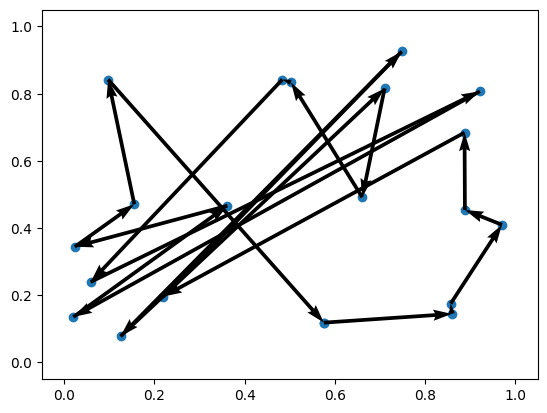

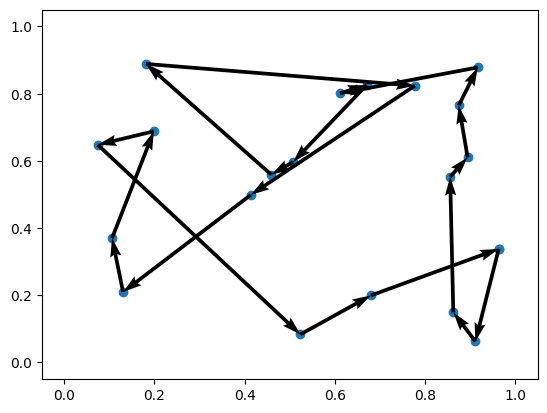

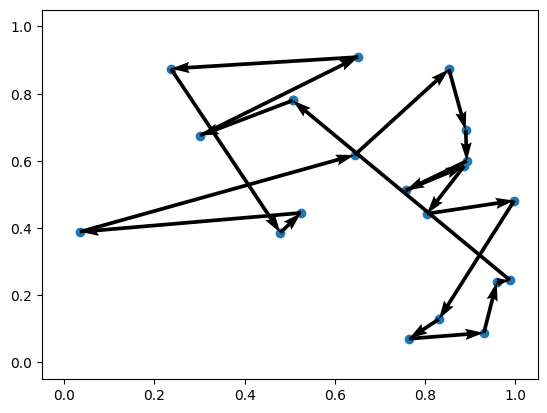

In [5]:
# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = lit_module.model.to(device)
out = model(td_init, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

### Lightning Trainer

The Lightning Trainer handles the logging, checkpointing and more for you

In [6]:
# Lightning Trainer with few epochs
trainer = L.Trainer(
    max_epochs=3, # only few epochs for showcasing training
    accelerator="gpu", # use GPU if available, else you can use others as "cpu"
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Faster training with Lightning with mixed precision
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/botu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


### Fit the model

In [7]:
trainer.fit(lit_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
No optimizer specified, using default

  | Name  | Type           | Params
-----------------------------------------
0 | env   | TSPEnv         | 0     
1 | model | AttentionModel | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.669     Total estimated model params size (MB)


/home/botu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2: 100%|██████████| 196/196 [00:06<00:00, 31.37it/s, v_num=4, train/reward=-4.14, train/loss=-.0728, val/reward=-4.10]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 196/196 [00:10<00:00, 18.50it/s, v_num=4, train/reward=-4.14, train/loss=-.0728, val/reward=-4.10]


### Testing

Tour lengths: ['4.03', '3.88', '4.21']


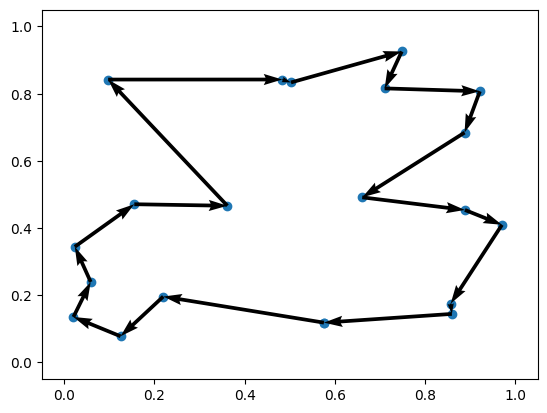

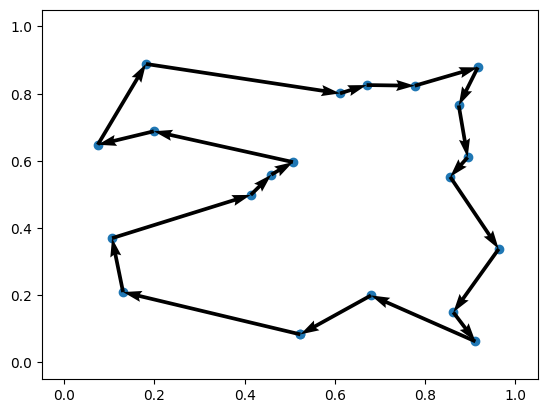

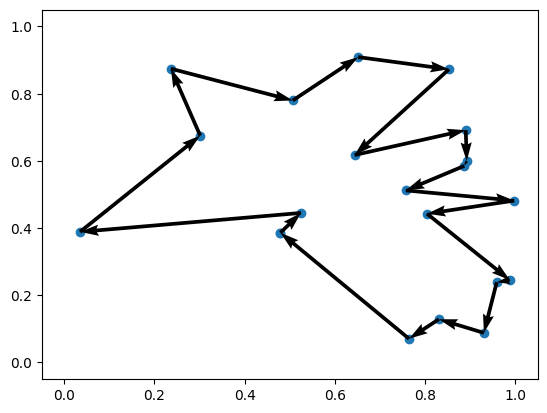

In [8]:
# Greedy rollouts over trained model (same states as previous plot)
model = lit_module.model.to(device)
out = model(td_init, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

We can see that even after just 3 epochs, our trained AM is able to find much better solutions than the random policy! 🎉